# RQ2: Does the difference in hours between timezones affect the review speed in the repository?
In the below:
- We read the preprocessed data from the corresponding file
- Plot a scatter plot of the data to visually examine the relationship between the independent and dependent variables. This step can help us identify any potential patterns or outliers.
- Perform the Shapiro Wilk & QQ-plot tests for normal distribution (and visualize) on our dependent variable

We find out:
- From the scatter plot, we can see that the relationship of our data is not linear.
- That our dependent variable does not follow a ND. This is because the p-value of the Shapiro Wilk test is not higher than 0.05 so we accept the null hypothesis (i.e., that the data are not normally distributed). 
- We also see a visualization of the non-normality in the QQ-plot. If the time-to-merge was a ND variable, then the data point would have followed the straight diagonal line. Deviation from the straight line suggests a departure from the expected distribution. In our case, that the data deviate upward from the line, it indicates that the observed data has heavier tails or is more spread out than the theoretical distribution.

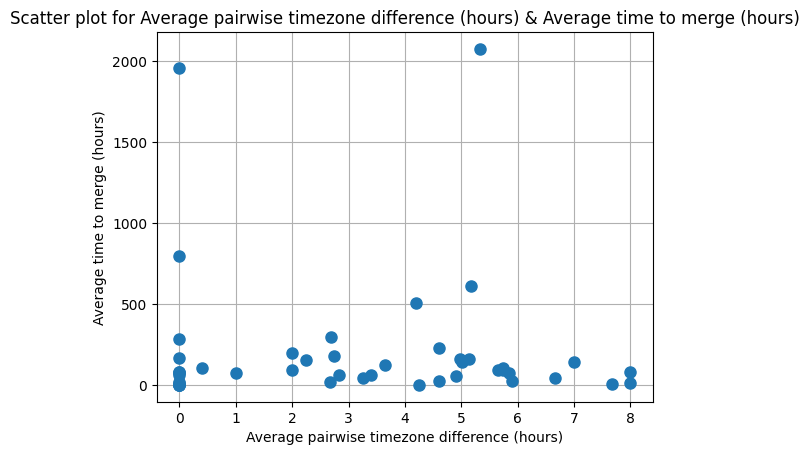

Average time to merge (hours) does not follow a normal distribution (p value = 1.0349549342536513e-11 < 0.05)


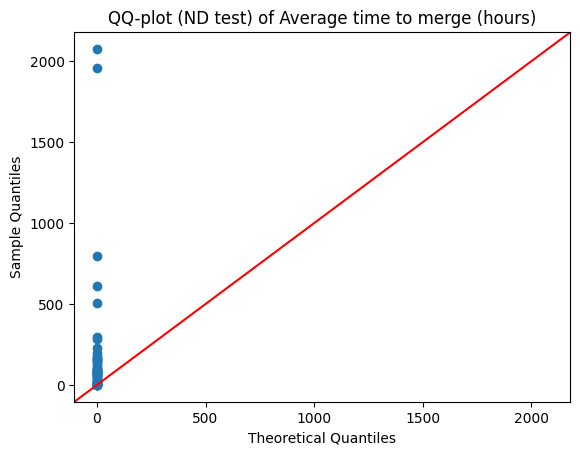

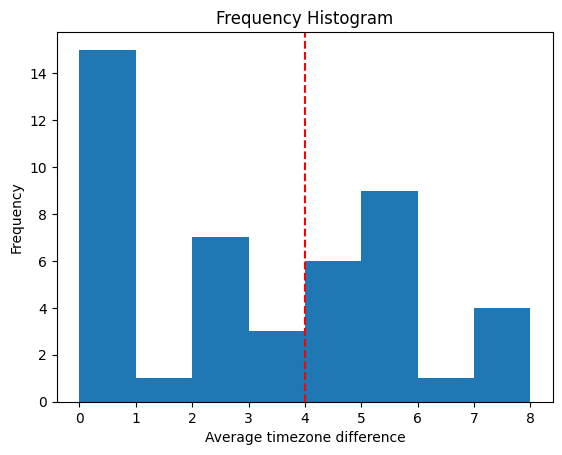

AttributeError: module 'stats' has no attribute 'mannwhitneyu'

In [32]:
# READ DATA FROM PROCESSED DATASET
import json
import pendulum
import matplotlib.pyplot as plt

def tz_diff(city1, city2, on=None):
    """
    Returns the difference in hours between the time zone of city1 and city2.

    As not all time zones are separated by an integer number of hours, this
    function returns a float.

    As time zones are political entities, their definitions can change over time.
    This is complicated by the fact that daylight savings time does not start
    and end on the same days uniformly across the globe. This means that there are
    certain days of the year when the returned value between `Europe/Berlin` and
    `America/New_York` is _not_ `6.0`.

    By default, this function always assumes that you want the current
    definition. If you prefer to specify, set `on` to the date of your choice.
    It should be a `Pendulum` object.

    This function returns the number of hours which must be added to the city1 time
    in order to get the city2 time. For example,
    ```python
    >>> tz_diff('Europe/Berlin', 'America/New_York')
    -6.0
    >>> tz_diff('Europe/Berlin', 'Asia/Kabul')
    2.5
    ```
    """
    if on is None:
        on = pendulum.today()
    diff = (on.set(tz=city1) - on.set(tz=city2)).total_hours()

    # what about the diff from Tokyo to Honolulu? Right now the result is -19.0
    # it should be 5.0; Honolulu is naturally east of Tokyo, just not so around
    # the date line
    if abs(diff) > 12.0:
        if diff < 0.0:
            diff += 24.0
        else:
            diff -= 24.0
    return diff

# Opening JSON file
f = open('processed_data/RQ1_2_Locations_PR.json')
data = json.load(f)
# x values is the indpendent (timezone difference), y are the dependent (time to merge)
x_values=[]
y_values=[]
for repo in data:
	# get average tz difference (PAIRWISE!)
    locations=repo["locations"]
    tz_sum=0
    pairs_count=0
    for i in range(len(locations)):
        for j in range(i+1, len(locations)):
            tz_sum+=abs(tz_diff(locations[i], locations[j]))
            pairs_count+=1
    if pairs_count!=0: # (avoid div by 0)
        x_values.append(tz_sum/pairs_count)
    elif len(locations) == 1: #only 1 user has locaiton available
        x_values.append(0)
    # get average time-to-merge
    y_values.append(repo["time_to_merge_average"])

def create_dot_plot(x_values, y_values, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.plot(x_values, y_values, 'o', markersize=8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    plt.title(f'Scatter plot for {xlabel} & {ylabel}')
    plt.show()
x_label='Average pairwise timezone difference (hours)'
y_label = 'Average time to merge (hours)'
create_dot_plot(x_values, y_values, x_label, y_label)

# Closing file
f.close()


# CHECK IF THE DEPENDENT VARIABLE IS NORMALLY DISTRIBUTED
# SHAPIRO-WILK TEST
from scipy.stats import norm
from scipy.stats import shapiro

def test_ShapiroWilk(values, label):
    res = shapiro(values)
    if res.pvalue>0.05: # if true, then normal distibution
        print(f'{label} follows a normal distribution (p value = {res.pvalue} > 0.05)')
    else:
        print(f'{label} does not follow a normal distribution (p value = {res.pvalue} < 0.05)')

test_ShapiroWilk(y_values, y_label)

# QQ-PLOT
import statsmodels.api as sm
import pylab
import numpy as np
def get_QQPlot(values, label):
    values=np.array(values) # data need to be in an array
    sm.qqplot(values, line='45')
    pylab.title(f'QQ-plot (ND test) of {label}')
    pylab.show()

get_QQPlot(y_values, y_label)

# T-TEST FOR AVERAGE DIFFERENCE
# histogram of differences to set a threshold
import math
bin_size=1
plt.hist(x_values, bins=range(0, math.ceil(max(x_values))+bin_size, bin_size)) # get bins of size 'bin_size'
plt.gca().set(title='Frequency Histogram', xlabel= 'Average timezone difference', ylabel='Frequency')

# vertical line for threshold (<= and > 4 hours)
# Add a vertical line at a specific x-coordinate
line_position = 4  # x-coordinate where the line should be placed
plt.axvline(x=line_position, color='r', linestyle='--')
plt.show()

# TODO
# # MANN-WITNEY U TEST: 
# import stats
# u_stat, p_value = stats.mannwhitneyu(x_values, y_values)

# print(f'U-statistic: {u_stat}')
# print(f'P-value: {p_value}')

# # Check if the result is statistically significant
# if p_value < 0.05:
#     print("The difference between the two metrics is statistically significant.")
# else:
#     print("No significant difference between the two metrics.")

In the below:
- We compute for the 75th percentile of the time-to-merge to avoid outliers that lie above the 25% percent.
- Scatter plot to examine the relationship of the 75th percentile and the average timezone difference.
- Test the normality of the above measure
- Spearman correlation between the average difference in timezones in each repository & the 75 percentile of time to merge.

We find:
- Non-normally distributed
- No significant association

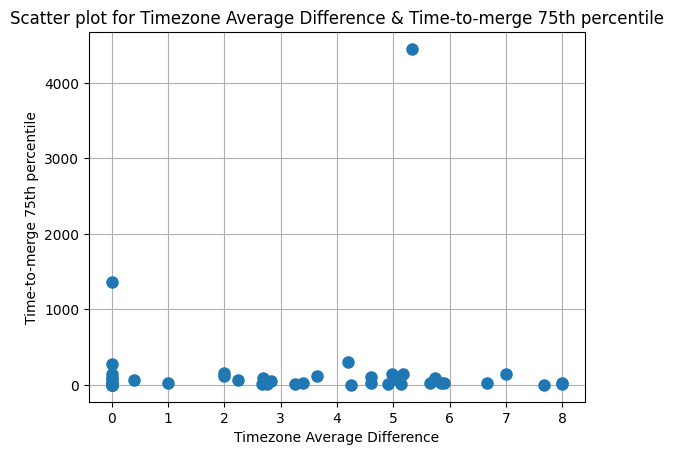

Time-to-merge 75th percentile does not follow a normal distribution (p value = 6.367505806480211e-14 < 0.05)


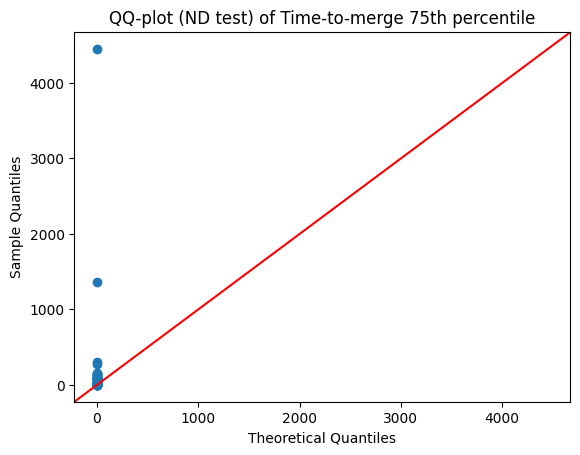

Spearman correlation: 0.10529376459418421
P-value: 0.48616379913273455
There is no statistically significant association between the average difference between timezones and the 75th percentile of time to merge.


In [37]:
import numpy as np
from scipy import stats

# READ AGAIN THE DATA
# to get all times-to-merge for each repo, and not only the average

# Simulated data: list of lists where each sublist represents 'time to merge' in hours for pull requests in one repository
# time_to_merge_data = [
#     [1, 2, 3, 4, 5],  # Repository 1
#     [2, 3, 4, 5, 6],  # Repository 2
#     [1, 3, 5, 7, 9],  # Repository 3
#     [2, 4, 6, 8, 10], # Repository 4
#     [1, 2, 2, 3, 3]   # Repository 5
# ]
time_to_merge_data=[]

for repo in data:
    time_to_merge_data.append(repo["time_to_merge"])

# CALCULATE THE 75TH PERCENTILE of TIME-TO-MERGE FOR EACH REPO
time_to_merge_75th = [np.percentile(data, 75) for data in time_to_merge_data]

# CREATE DOT PLOT
create_dot_plot(x_values, time_to_merge_75th, 'Timezone Average Difference', 'Time-to-merge 75th percentile')

# CHECK NORMALITY & VISUALIZE
test_ShapiroWilk(time_to_merge_75th, 'Time-to-merge 75th percentile')
get_QQPlot(time_to_merge_75th, 'Time-to-merge 75th percentile') #TODO: why less data here?


# TODO: Corresponding number of distinct time zones for each repository
# Corresponding number of average time zone difference
timezones = x_values # Metric 1

# Perform Spearman rank correlation test
correlation, p_value = stats.spearmanr(timezones, time_to_merge_75th)

print(f'Spearman correlation: {correlation}')
print(f'P-value: {p_value}')

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant association between the average difference between timezones and the 75th percentile of time to merge.")
else:
    print("There is no statistically significant association between the average difference between timezones and the 75th percentile of time to merge.")
